In [98]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import math
from tensorflow.contrib import rnn

%matplotlib notebook

In [122]:
# Parameters
learning_rate = 0.001
training_iters = 2500
batch_size = 1
display_step = 10

# Network Parameters
n_input = 1 # MNIST data input (img shape: 28*28)
n_steps = 100 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = n_steps # MNIST total classes (0-9 digits)

# Data Parameters
dataParam = dict(
    freq = 2,
    section = 8,
    baseline = 2,
    rows = 300,
    stop = 20,
    n_steps = n_steps,
    n_input = n_input
)

In [123]:
class DataGenerator:
#     def __init__(self, **kwargs):
    def __init__(self, kwargs):
        self.freq = kwargs['freq']
        self.section = kwargs['section']
        self.baseline = kwargs['baseline']
        self.rows = kwargs['rows']
        self.stop = kwargs['stop']
        self.n_steps = kwargs['n_steps']
        self.n_input = kwargs['n_input']
        self.it = 0;
        self.epoch = 0;
        
    def _generate_data(self, freq, section, baseline, rows=10, stop=100, steps=250):
        data = np.tile(np.linspace(0, stop, steps), rows).reshape(rows, steps)
        f, s, b = np.random.random((3, rows)) * np.array([freq, section, baseline])[:,np.newaxis]
        return np.sin(data * f[:,np.newaxis] + s[:,np.newaxis]) + b[:,np.newaxis]

    def _make_time_steps(self, arr, n_steps, n_input):
        B = np.zeros(shape=(arr.shape[0], n_steps, n_input))
        for i in range(n_steps):B[:,i,:]=arr[:,i:n_input+i]
        return B, arr[:,n_input:]
    
    def generate_train_data(self, r=0):
        r = self.rows if r == 0 else r
        X_orig = self._generate_data(self.freq, self.section, self.baseline, 
                                     rows=r, stop=self.stop, steps=self.n_steps + self.n_input)
        X, Y = self._make_time_steps(X_orig, self.n_steps, self.n_input)
        self.X_orig, self.X_train, self.Y_train = X_orig, X, Y

    def generate(self, r=0):
        r = self.rows if r == 0 else r
        X_orig = self._generate_data(self.freq, self.section, self.baseline, 
                                     rows=r, stop=self.stop, steps=self.n_steps + self.n_input)
        X, Y = self._make_time_steps(X_orig, self.n_steps, self.n_input)
        return X_orig, X, Y
    
    def next(self, num=5):
        if self.X_orig.shape[0] % num != 0:
            raise Exception('Invalid num')
            
        i = self.it
        self.it += num
        if self.it >= self.X_orig.shape[0]:
            self.it = 0
            self.epoch += 1
        return self.X_orig[i:i+num], self.X_train[i:i+num], self.Y_train[i:i+num]

dg = DataGenerator(dataParam)
dg.generate_train_data()
X_orig, X_train, Y_train = dg.next(10)

print(X_orig.shape)
print(X_train.shape)
print(Y_train.shape)
print(dg.X_orig.shape)

(10, 101)
(10, 100, 1)
(10, 100)
(300, 101)


In [124]:
tf.reset_default_graph()
g = tf.Graph()
sess = tf.InteractiveSession(graph=g)

x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

def RNN(x, weights, biases):
    x = tf.unstack(x, n_steps, 1)
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)

cost = tf.nn.l2_loss(pred - y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

sess.run(init)
step = 1
while step * batch_size < training_iters:
    _, batch_x, batch_y = dg.next(30)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    if step % display_step == 0:
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(loss)) 
#               + ", Training Accuracy= " + "{:.5f}".format(acc))
    step += 1
    
print("Optimization Finished!")

test_len = 128
_, test_data, test_label = dg.generate(test_len)
print("Testing Accuracy:", \
    sess.run(cost, feed_dict={x: test_data, y: test_label}))

Iter 10, Minibatch Loss= 1488.178223
Iter 20, Minibatch Loss= 1349.791138
Iter 30, Minibatch Loss= 1083.867310
Iter 40, Minibatch Loss= 976.638977
Iter 50, Minibatch Loss= 910.493774
Iter 60, Minibatch Loss= 873.480652
Iter 70, Minibatch Loss= 853.979614
Iter 80, Minibatch Loss= 798.808960
Iter 90, Minibatch Loss= 775.989624
Iter 100, Minibatch Loss= 734.536621
Iter 110, Minibatch Loss= 727.521240
Iter 120, Minibatch Loss= 706.593933
Iter 130, Minibatch Loss= 696.019287
Iter 140, Minibatch Loss= 693.393188
Iter 150, Minibatch Loss= 672.298462
Iter 160, Minibatch Loss= 662.478271
Iter 170, Minibatch Loss= 674.278076
Iter 180, Minibatch Loss= 666.511475
Iter 190, Minibatch Loss= 669.416626
Iter 200, Minibatch Loss= 632.021606
Iter 210, Minibatch Loss= 621.933472
Iter 220, Minibatch Loss= 734.063232
Iter 230, Minibatch Loss= 635.689697
Iter 240, Minibatch Loss= 626.685852
Iter 250, Minibatch Loss= 599.070435
Iter 260, Minibatch Loss= 600.160156
Iter 270, Minibatch Loss= 594.438599
Iter 28

Iter 2230, Minibatch Loss= 16.112423
Iter 2240, Minibatch Loss= 20.333601
Iter 2250, Minibatch Loss= 18.783365
Iter 2260, Minibatch Loss= 16.958099
Iter 2270, Minibatch Loss= 18.668518
Iter 2280, Minibatch Loss= 18.312475
Iter 2290, Minibatch Loss= 17.302134
Iter 2300, Minibatch Loss= 14.089675
Iter 2310, Minibatch Loss= 15.159252
Iter 2320, Minibatch Loss= 13.610449
Iter 2330, Minibatch Loss= 13.912901
Iter 2340, Minibatch Loss= 17.290226
Iter 2350, Minibatch Loss= 13.375238
Iter 2360, Minibatch Loss= 12.823740
Iter 2370, Minibatch Loss= 12.283797
Iter 2380, Minibatch Loss= 11.679452
Iter 2390, Minibatch Loss= 11.748842
Iter 2400, Minibatch Loss= 11.299944
Iter 2410, Minibatch Loss= 11.211573
Iter 2420, Minibatch Loss= 11.191437
Iter 2430, Minibatch Loss= 11.049324
Iter 2440, Minibatch Loss= 10.987982
Iter 2450, Minibatch Loss= 10.830820
Iter 2460, Minibatch Loss= 10.699807
Iter 2470, Minibatch Loss= 10.624050
Iter 2480, Minibatch Loss= 10.534639
Iter 2490, Minibatch Loss= 10.379724
O

In [151]:
def plot(num=9, col=3, train=True, fig_count=0):
    fig = plt.figure(fig_count)
    if train:
        print('Train')
        X_orig, X, Y = dg.next(num)
    else:
        print('Test')
        X_orig, X, Y = dg.generate(num)
    prediction = sess.run(pred, feed_dict={x: X, y: Y})
    c = sess.run(cost, feed_dict={x: X, y: Y})
    print("Cost %f" % c)
    print(np.sum(np.square(prediction - Y)/2, axis=1))
    t = np.linspace(0, dataParam['stop'], n_steps+n_input)
    row = math.ceil(num / col) 
    for i in range(0, num):
        plt.subplot(row,col,i+1)
        plt.plot(t, X_orig[i])
        plt.plot(t[-n_steps:], prediction[i])

<IPython.core.display.Javascript object>


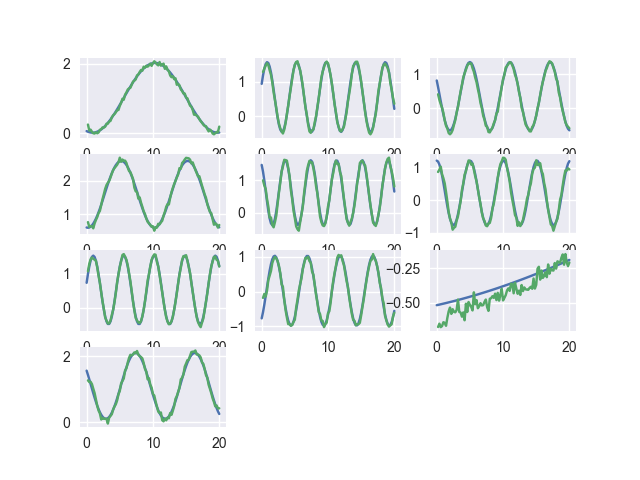

Train
Cost 2.099818
[ 0.1023902   0.0938969   0.1501551   0.15343269  0.28268191  0.44320412
  0.05324202  0.30224459  0.30397031  0.21460011]


<IPython.core.display.Javascript object>


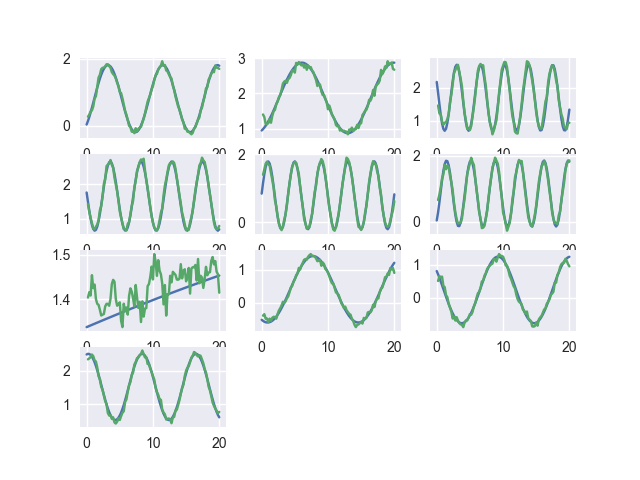

Test
Cost 2.872118
[ 0.17414454  0.39302323  0.64389552  0.18000849  0.18517381  0.36363973
  0.0876619   0.25432751  0.34480965  0.24543356]


In [154]:
fc = 1
plot(num=10, train=True, fig_count=fc)

fc += 1
plot(num=10, train=False, fig_count=fc)

### Analysis
* Model predicts well on highly frequency sin waves
    * This is because the generated data favor higher freq
* Low freq (more linear given the timestep frame) is more eratic
    * This is because with the given timestep frame, the zoomed in section of the sin wave gives the projection a linear resemblence
    * However, the model still have relatively low RMSE error because high freq sin waves has limited $\Delta(y)$.
    * So although estimates tend to over and under predict, the moving average remains on the line

In [108]:
def sample(X_init):
    init = X_init[:, 0, :]
    p = sess.run(pred, feed_dict={x: init}) 
    return p

In [156]:
sample_steps = 100
x_init = np.zeros((1,sample_steps, n_input))
x_init[0,0] = np.random.random(n_input)

In [121]:
graph_keys = sess.graph.get_all_collection_keys()
for i in graph_keys:
    print(i)
    display(sess.graph.get_collection(i))

variables


[<tf.Variable 'Variable:0' shape=(128, 100) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'rnn/basic_lstm_cell/kernel:0' shape=(133, 512) dtype=float32_ref>,
 <tf.Variable 'rnn/basic_lstm_cell/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'Variable/Adam:0' shape=(128, 100) dtype=float32_ref>,
 <tf.Variable 'Variable/Adam_1:0' shape=(128, 100) dtype=float32_ref>,
 <tf.Variable 'Variable_1/Adam:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'Variable_1/Adam_1:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'rnn/basic_lstm_cell/kernel/Adam:0' shape=(133, 512) dtype=float32_ref>,
 <tf.Variable 'rnn/basic_lstm_cell/kernel/Adam_1:0' shape=(133, 512) dtype=float32_ref>,
 <tf.Variable 'rnn/basic_lstm_cell/bias/Adam:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'rnn/basic_lstm_cell/bias/Adam_1:0' shape=(512,) dt

trainable_variables


[<tf.Variable 'Variable:0' shape=(128, 100) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'rnn/basic_lstm_cell/kernel:0' shape=(133, 512) dtype=float32_ref>,
 <tf.Variable 'rnn/basic_lstm_cell/bias:0' shape=(512,) dtype=float32_ref>]

update_ops


[]

train_op


[<tf.Operation 'Adam' type=NoOp>]